In [ ]:
import os
import sys
from os import listdir
from os.path import isfile, join
import IPython.display as ipd
import librosa 
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wav
import numpy as np
from timeit import default_timer as timer

# Implementing CNN with Mel and Chroma_cqt

In [ ]:
filename='E:/Thesis/Dataset/UrbanSound8K/audio/fold3/6988-5-0-4.wav'
ipd.Audio(filename)

In [ ]:
def extract_MElandChroma_cqt(filename):
    audio,sample_rate=librosa.load(filename, res_type='kaiser_fast')
    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=audio, sr=sample_rate,n_chroma=50).T,axis=0)
    mel=np.mean(librosa.feature.melspectrogram(audio ,sr=sample_rate, n_mels=50,fmax=8000).T, axis=0)
    
    return chroma_cqt, mel

In [ ]:
start_time=timer()
filename='E:/Thesis/Dataset/UrbanSound8K/audio/fold3/6988-5-0-4.wav'
a,b=extract_MElandChroma_cqt(filename)
end_time=timer()
print('time to extract features from one file: {:.3f}sec'.format((end_time-start_time)/60))
print(a.shape, b.shape)

In [ ]:
metadata=pd.read_csv('E:/Thesis/Dataset/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

In [ ]:
fold_list = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

In [ ]:
stacked_features = []
exceptions=0

start_time = timer()
for i in range(10):
    # get file names
    mypath = 'E:/Thesis/Dataset/UrbanSound8K/audio/'+ fold_list[i] + '/'
    files = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    for fn in files:
        try: # extract features
            a,b=extract_MElandChroma_cqt(fn)
            features=np.reshape((np.hstack([a,b])),(20,5))
             
    
            
            
        except: # else exception (.ds_store files are part of mac file systems)
            print(fn)
            exceptions += 1
            continue
            
        l_row = metadata.loc[metadata['slice_file_name']==fn.split('/')[-1]].values.tolist()
        label = l_row[0][-1]
        fold = i+1
    
        stacked_features.append([features, features.shape, label, fold])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

In [ ]:
cols=['Features_MFCC_ChromaSTFT', 'Matrix_Shape', 'Label', 'Fold']
Stacked_feature_pd=pd.DataFrame(data=stacked_features , columns=cols)
Stacked_feature_pd.head()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


X = np.array(Stacked_feature_pd.Features_MFCC_ChromaSTFT.tolist())
y = np.array(Stacked_feature_pd.Label.tolist())


le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, yy.shape)

In [ ]:
x_train =x_train.reshape(x_train.shape[0], 20, 5,1)
x_test=x_test.reshape(x_test.shape[0],20,5, 1)

print(x_train.shape, x_test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

model=Sequential()
model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))

#model.add(Flatten())

model.add(GlobalAveragePooling2D())


model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(10,activation="softmax"))

In [16]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 2, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

1747/1747 [==============================] - 3s 2ms/step
Pre-training accuracy: 8.4144%


In [18]:
start_time=timer()
history=model.fit(x_train,y_train,batch_size=50,epochs=30,validation_data=(x_test,y_test))
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Train on 6985 samples, validate on 1747 samples
Epoch 1/30
6985/6985 [==============================] - 12s 2ms/step - loss: 2.2301 - accuracy: 0.1910 - val_loss: 2.1384 - val_accuracy: 0.2679
Epoch 2/30
6985/6985 [==============================] - 9s 1ms/step - loss: 2.0468 - accuracy: 0.2792 - val_loss: 1.9128 - val_accuracy: 0.3663
Epoch 3/30
6985/6985 [==============================] - 9s 1ms/step - loss: 1.8259 - accuracy: 0.3705 - val_loss: 1.6397 - val_accuracy: 0.4327
Epoch 4/30
6985/6985 [==============================] - 9s 1ms/step - loss: 1.6334 - accuracy: 0.4299 - val_loss: 1.5582 - val_accuracy: 0.4837
Epoch 5/30
6985/6985 [==============================] - 9s 1ms/step - loss: 1.5332 - accuracy: 0.4687 - val_loss: 1.4468 - val_accuracy: 0.5066
Epoch 6/30
6985/6985 [==============================] - 9s 1ms/step - loss: 1.4369 - accuracy: 0.5157 - val_loss: 1.4287 - val_accuracy: 0.5192
Epoch 7/30
6985/6985 [==============================] - 9s 1ms/step - loss: 1.3491 - ac

In [19]:
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

6985/6985 [==============================] - 4s 571us/step
Training Accuracy:  0.8813170790672302
1747/1747 [==============================] - 1s 572us/step
Testing Accuracy:  0.7990841269493103


In [20]:
def plot_accuracy():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('No of epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss():
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Testing')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('No of epoch')
    plt.legend(loc="upper left")
    plt.show()
    

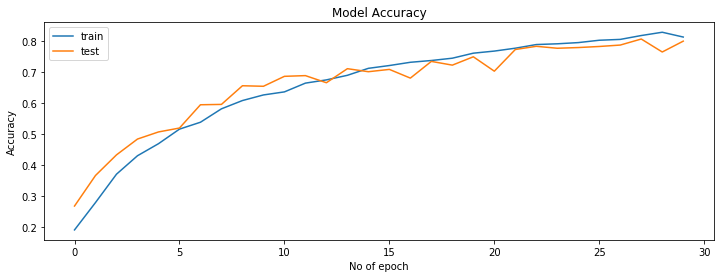

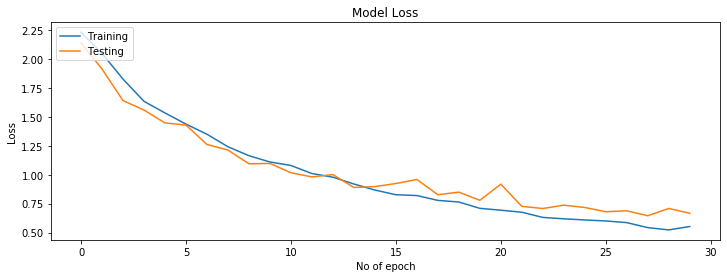

In [22]:
plt.figure(figsize=(12,4))
plot_accuracy()
plt.figure(figsize=(12,4))
plot_loss()

In [23]:
Class_Label = {'Air_conditioner':0, 'Car_horn':1, 'Children_playing':2, 'Dog_Bark':3, 
               'Drilling':4,'Engine_idling':5, 'Gun_Shot' :6, 'Jackhammer': 7 ,'Siren':8,'Street_Music':9 }

In [24]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = Class_Label.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1747,) (1747,)
                  precision    recall  f1-score   support

 Air_conditioner       0.80      0.92      0.86       195
        Car_horn       0.94      0.67      0.78        73
Children_playing       0.64      0.69      0.66       198
        Dog_Bark       0.78      0.68      0.73       190
        Drilling       0.84      0.82      0.83       222
   Engine_idling       0.90      0.87      0.88       197
        Gun_Shot       0.85      0.70      0.77        57
      Jackhammer       0.85      0.92      0.88       217
           Siren       0.82      0.87      0.85       204
    Street_Music       0.71      0.66      0.69       194

        accuracy                           0.80      1747
       macro avg       0.81      0.78      0.79      1747
    weighted avg       0.80      0.80      0.80      1747



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))
metadata_cm=confusion_matrix(y_true, y_pred)

[[180   0   1   2   1   2   0   5   2   2]
 [  3  49   3   1   3   1   0   0   5   8]
 [ 11   0 137  10  10   1   3   2  12  12]
 [  2   1  28 129   6   4   0   1  10   9]
 [  0   0   1   6 182   3   0  19   1  10]
 [ 12   1   3   2   1 172   0   2   1   3]
 [  2   0   6   0   0   2  40   4   1   2]
 [  2   0   2   0   4   3   2 200   0   4]
 [  1   0  14   7   1   1   0   0 178   2]
 [ 13   1  20   8   8   3   2   3   7 129]]


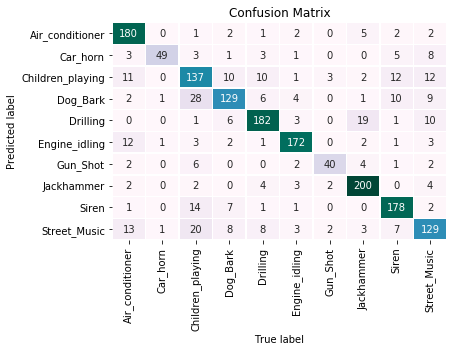

<Figure size 720x288 with 0 Axes>

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax=plt.subplot()
mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,4))
sns.heatmap(mat, square=False, annot=True, fmt='d',cbar=False,linewidths=.5,xticklabels=Class_Label.keys(),yticklabels=Class_Label.keys(), ax=ax, cmap='PuBuGn')
bottom, top= ax.get_ylim()
ax.set_ylim(bottom + 0.5 , top -0.5)
ax.set_title('Confusion Matrix')
ax.set_xlabel('True label')
ax.set_ylabel('Predicted label');

In [44]:
def print_prediction(file_name):
    a,b =extract_MElandChroma_cqt(file_name) 
    prediction_feature=np.reshape(np.hstack((a,b)),(20,5))
            
    prediction_feature = prediction_feature.reshape(1, 20, 5, 1)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [46]:
filename='E:/Thesis/Dataset/Sample Augmented Sound clips/Augmentation/Car Horn/71439-1-0-0/71439-1-0-0 Noise Added.wav'
print_prediction(filename)


The predicted class is: car_horn 

air_conditioner 		 :  0.02719913236796855926513671875000
car_horn 		 :  0.24080868065357208251953125000000
children_playing 		 :  0.04175462201237678527832031250000
dog_bark 		 :  0.15202026069164276123046875000000
drilling 		 :  0.04804234206676483154296875000000
engine_idling 		 :  0.20079308748245239257812500000000
gun_shot 		 :  0.08663919568061828613281250000000
jackhammer 		 :  0.01005834527313709259033203125000
siren 		 :  0.02761969342827796936035156250000
street_music 		 :  0.16506463289260864257812500000000


In [47]:
filename='E:/Thesis/Dataset/Sample Augmented Sound clips/Augmentation/Car Horn/71439-1-0-0/71439-1-0-0 Noise Added + Pitch Down.wav'
print_prediction(filename)

The predicted class is: car_horn 

air_conditioner 		 :  0.00000000000119490365952518162729
car_horn 		 :  0.99999201297760009765625000000000
children_playing 		 :  0.00000007019202996616513701155782
dog_bark 		 :  0.00000222823928197612985968589783
drilling 		 :  0.00000000834708835384390113176778
engine_idling 		 :  0.00000010000722738823242252692580
gun_shot 		 :  0.00000000002443544151742305103880
jackhammer 		 :  0.00000000000003853140679785371780
siren 		 :  0.00000000000127989448466675481697
street_music 		 :  0.00000552966002942412160336971283


In [48]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

In [62]:
accuracies=acc_per_class(mat)
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

pd.DataFrame({'CLASS':labels, 'ACCURACY': accuracies}).sort_values(by='ACCURACY', ascending=False)


,CLASS,ACCURACY
0,Air Conditioner,92.307692
7,Jackhammer,92.165899
5,Engine Idling,87.309645
8,Siren,87.254902
4,Drilling,81.981982
6,Gun Shot,70.175439
2,Children Playing,69.191919
3,Dog bark,67.894737
1,Car Horn,67.123288
9,Street Music,66.494845


In [93]:
accuracies=acc_per_class(mat)
print(accuracies)
Y=np.around(accuracies , decimals=1)
print(Y)

[92.3076923076923, 67.12328767123287, 69.1919191919192, 67.89473684210526, 81.98198198198197, 87.30964467005076, 70.17543859649122, 92.16589861751152, 87.25490196078431, 66.49484536082474]
[92.3 67.1 69.2 67.9 82.  87.3 70.2 92.2 87.3 66.5]


Text(0.5, 1.0, 'Accuracy per Class')

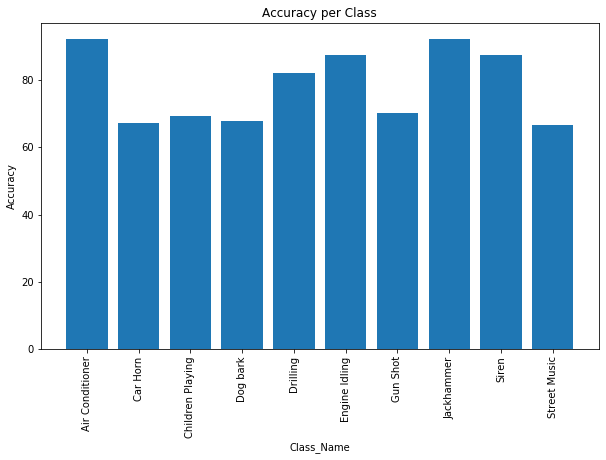

In [110]:
Y=np.around(accuracies , decimals=1)
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]
index=np.arange(len(labels))
plt.figure(figsize=(10,6))
plt.bar(index, Y)
plt.xticks(index, labels, rotation=90)
plt.xlabel('Class_Name')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')

In [111]:
from tools import Plot
Plot.plot_accuracy()

ImportError: cannot import name 'Plot' from 'tools' (unknown location)